In [39]:
import json
import numpy as np
import pyrealsense2 as rs
import matplotlib
import matplotlib.pyplot as plt
from typing import List
import os
import numpy as np
import cv2
from scipy import spatial

In [2]:
with open("dataset_final_rs_1.json", "r") as f:
    content = f.read()
dataset = json.loads(content)

tracklet_indices = np.load("tracklet_indices_rs_1_mohamad.npy",allow_pickle=True).item()
tracklet_indices1 = np.load("tracklet_indices_rs_1_mahya.npy",allow_pickle=True).item()

In [3]:
def reject_outliers(data, m=2.0):
    """Reject outliers from distance meaurement"""
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d / mdev if mdev else 0.0
    return data[s < m]


def get_depth(lidar_distances: np.ndarray, acceptable_tolerance: float) -> float:
    sub_sample = np.random.choice(lidar_distances, int(len(lidar_distances) / 6))
    depth = reject_outliers(sub_sample, acceptable_tolerance).mean()
    return depth

In [4]:
def read_calib_file(filepath):
    with open(filepath, "r") as f:
        json_obj = json.loads(f.read())
        intrinsics = rs.intrinsics()
        intrinsics.coeffs = json_obj["coeffs"]
        intrinsics.fx = json_obj["fx"]
        intrinsics.fy = json_obj["fy"]
        intrinsics.height = json_obj["height"]
        intrinsics.width = json_obj["width"]
        if json_obj["model"] == "distortion.brown_conrady":
            intrinsics.model = rs.distortion.brown_conrady
        elif json_obj["model"] == "distortion.inverse_brown_conrady":
            intrinsics.model = rs.distortion.inverse_brown_conrady
        intrinsics.ppx = json_obj["ppx"]
        intrinsics.ppy = json_obj["ppy"]
    return intrinsics

In [5]:
depth_calib = read_calib_file("extracted_rs/calib/depth_intrinsics.json")
color_calib = read_calib_file("extracted_rs/calib/color_intrinsics.json")

In [64]:
class RsProjection:
    def __init__(self, depth_intrinsics, color_intrinsics):
        self.depth_calib = depth_intrinsics
        self.color_calib = color_intrinsics

    def wcs2ccs(self, xyd):
        """convert a point from word coordinate system to camera coordinate system(point to pixel)

        designed to convert 3D point gathered from LIDAR + Camera for KITTI dataset

        Parameters
        ----------
        xyd: list of floats
            x: in meter
            y: in meter
            d: in meter
        calib: np.dfarray
            calibration parameters

        Returns
        -------
        xyd: list
            x,y in pixel
            d in meter
        """
        pixel = np.zeros((3,))
        pixel[:2] = rs.rs2_project_point_to_pixel(self.depth_calib, xyd)
        return pixel

    def ccs2wcs(self, xyd: List):
        """convert a point from camera coordinate system to word coordinate system (pixel to point)

        designed to convert 3D point gathered from LIDAR + Camera for KITTI dataset

        Parameters
        ----------
        xyd: list of floats
            x: in pixel
            y: in pixel
            d: depth in meter
        calib: np.dfarray
            calibration parameters

        Returns
        -------
        xyd in meter in world coordinate system
        """
        depth_point = rs.rs2_deproject_pixel_to_point(self.depth_calib, xyd[0:2], xyd[2])
        return depth_point


In [119]:
class Detection(object):
    """
    This class represents a bounding box detection in a single image.

    Parameters
    ----------
    tlwh : array_like
        Bounding box in format `(x, y, w, h)`.
    confidence : float
        Detector confidence score.
    feature : array_like
        A feature vector that describes the object contained in this image.

    Attributes
    ----------
    tlwh : np.ndarray
        Bounding box in format `(top left x, top left y, width, height)` in pixel.
    confidence : np.ndarray
        Detector confidence score.
    feature : np.ndarray | NoneType
        A feature vector that describes the object contained in this image.

    """

    def __init__(self, tlwh, depth, confidence, feature, projector: RsProjection):
        self.tlwh = np.asarray(tlwh, dtype=np.float)
        self.depth = depth
        self.confidence = float(confidence)
        self.feature = np.asarray(feature, dtype=np.float32)
        self.projector = projector

    def to_xyzah_ccs(self):
        """Convert bounding box to format `(center x (pixel), center y (pixel), depth (meter), aspect ratio (float),
        height (float))`, where the aspect ratio is `width / height`.
        """
        ret = np.zeros(shape=(5,))
        ret[:2] = self.tlwh[:2] + self.tlwh[2:] / 2
        ret[2] = self.depth
        ret[3] = self.tlwh[2] / self.tlwh[3]
        ret[4] = self.tlwh[3]
        return ret

    def to_xyz_ccs(self):
        xyzah_ccs = self.to_xyzah_ccs()
        return xyzah_ccs[:3]

    def to_tlbr_ccs(self):
        """in order to visualize bbounding box"""
        xyzah_ccs = self.to_xyzah_ccs()
        w = xyzah_ccs[3] * xyzah_ccs[4]
        h = xyzah_ccs[4]
        tlbr = np.array([int(xyzah_ccs[0] - w / 2), int(xyzah_ccs[1] - h / 2), int(w), int(h)])
        tlbr[2:4] += tlbr[0:2]
        return tlbr

    def to_xyz_bottom_wcs(self):
        xyzah_ccs = self.to_xyzah_ccs()
        xyzah_ccs[1] += xyzah_ccs[4] / 2
        xyz_wcs = self.projector.ccs2wcs(
            np.array([xyzah_ccs[0], xyzah_ccs[1] , xyzah_ccs[2]])
        )

        return np.array([xyz_wcs[0], xyz_wcs[1], xyz_wcs[2], xyzah_ccs[3], xyzah_ccs[4]])

    def to_xyzah_wcs(self):
        xyzah_ccs = self.to_xyzah_ccs()
        xyz_wcs = self.projector.ccs2wcs(
            np.array([xyzah_ccs[0] , xyzah_ccs[1] , xyzah_ccs[2]])
        )

        return np.array([xyz_wcs[0], xyz_wcs[1], xyz_wcs[2], xyzah_ccs[3], xyzah_ccs[4]])

    def to_xyz_wcs(self):
        xyzah_ccs = self.to_xyzah_ccs()
        xyz_wcs = self.projector.ccs2wcs(
            np.array([xyzah_ccs[0], xyzah_ccs[1], xyzah_ccs[2]])
        )
        return xyz_wcs

    def to_size_wcs(self):
        tlbr_ccs = self.to_tlbr_ccs()
        tl_wcs = self.projector.ccs2wcs(np.array([tlbr_ccs[0], tlbr_ccs[1], self.depth]))

        br_wcs = self.projector.ccs2wcs(np.array([tlbr_ccs[2], tlbr_ccs[3], self.depth]))

        height = abs(tl_wcs[1]) + abs(br_wcs[1])
        width = 0.667334
        length = 0.902490
        return np.array([height, width, length])


In [120]:
projector = RsProjection(depth_calib, color_calib)

depthes = []
detections = []
for i in range(len(dataset)):
    print(f"loop: {i}")
    step = dataset[i]
    img_name = step["img_name"]
    objects = np.array(step["objects"])
    track_index = tracklet_indices[img_name]
    depth = None
    if track_index >= 0:
        tracked_object = objects[track_index]
        lidars = np.array(tracked_object["lidars"]).flatten()
        depth = get_depth(lidars, 0.5)
        features = np.array(tracked_object["features"])
        depthes.append(depth)
        detections.append(Detection(np.array(tracked_object["bbox"]), depth, 100, features, projector))

loop: 0
loop: 1
loop: 2
loop: 3
loop: 4
loop: 5
loop: 6
loop: 7
loop: 8
loop: 9
loop: 10
loop: 11
loop: 12
loop: 13
loop: 14
loop: 15
loop: 16
loop: 17
loop: 18
loop: 19
loop: 20
loop: 21
loop: 22
loop: 23
loop: 24
loop: 25
loop: 26
loop: 27
loop: 28
loop: 29
loop: 30
loop: 31
loop: 32
loop: 33
loop: 34
loop: 35
loop: 36
loop: 37
loop: 38
loop: 39
loop: 40
loop: 41
loop: 42
loop: 43
loop: 44
loop: 45
loop: 46
loop: 47
loop: 48
loop: 49
loop: 50
loop: 51
loop: 52
loop: 53
loop: 54
loop: 55
loop: 56
loop: 57
loop: 58
loop: 59
loop: 60
loop: 61
loop: 62
loop: 63
loop: 64
loop: 65
loop: 66
loop: 67
loop: 68
loop: 69
loop: 70
loop: 71
loop: 72
loop: 73
loop: 74
loop: 75
loop: 76
loop: 77
loop: 78
loop: 79
loop: 80
loop: 81
loop: 82
loop: 83
loop: 84
loop: 85
loop: 86
loop: 87
loop: 88
loop: 89
loop: 90
loop: 91
loop: 92
loop: 93
loop: 94
loop: 95
loop: 96
loop: 97
loop: 98
loop: 99
loop: 100
loop: 101
loop: 102
loop: 103
loop: 104
loop: 105
loop: 106
loop: 107
loop: 108
loop: 109
loop: 110


/home/eam/anaconda3/envs/alphapose_yolo4/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


loop: 288
loop: 289
loop: 290
loop: 291
loop: 292
loop: 293
loop: 294
loop: 295
loop: 296
loop: 297
loop: 298
loop: 299
loop: 300
loop: 301
loop: 302
loop: 303
loop: 304
loop: 305
loop: 306
loop: 307
loop: 308
loop: 309
loop: 310
loop: 311
loop: 312
loop: 313
loop: 314
loop: 315
loop: 316
loop: 317
loop: 318
loop: 319
loop: 320
loop: 321
loop: 322
loop: 323
loop: 324
loop: 325
loop: 326
loop: 327
loop: 328
loop: 329
loop: 330
loop: 331
loop: 332
loop: 333
loop: 334
loop: 335
loop: 336
loop: 337
loop: 338
loop: 339
loop: 340
loop: 341
loop: 342
loop: 343
loop: 344
loop: 345
loop: 346
loop: 347
loop: 348
loop: 349
loop: 350
loop: 351
loop: 352
loop: 353
loop: 354
loop: 355
loop: 356
loop: 357
loop: 358
loop: 359
loop: 360
loop: 361
loop: 362
loop: 363
loop: 364
loop: 365
loop: 366
loop: 367
loop: 368
loop: 369
loop: 370
loop: 371
loop: 372
loop: 373
loop: 374
loop: 375
loop: 376
loop: 377
loop: 378
loop: 379
loop: 380
loop: 381
loop: 382
loop: 383
loop: 384
loop: 385
loop: 386
loop: 387


/home/eam/anaconda3/envs/alphapose_yolo4/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice.
  # This is added back by InteractiveShellApp.init_path()
/home/eam/anaconda3/envs/alphapose_yolo4/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [121]:
depthes = np.array(depthes)
depthes = depthes.astype(np.float64)

In [122]:
print(len(depthes))
depthes = depthes[~np.isnan(depthes)]
print(len(depthes))

789
788


In [123]:
depthes = reject_outliers(depthes, 1.5)

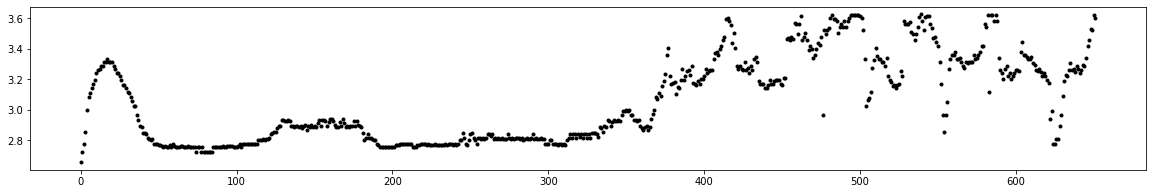

In [124]:
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(range(len(depthes)), depthes, '.', color='black');

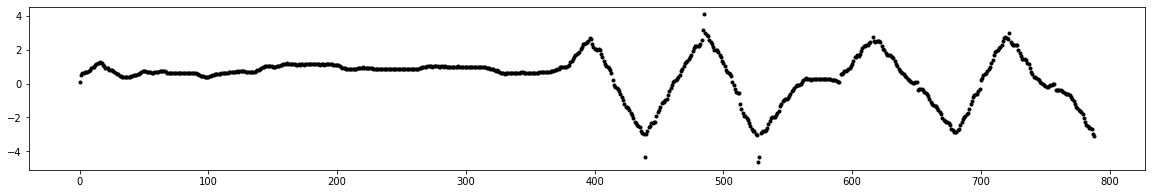

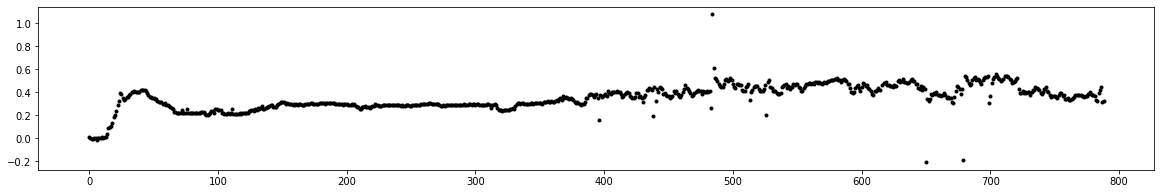

In [125]:
np_detections = np.array([x.to_xyz_wcs()[0:2] for x in detections])
plt.plot(range(np_detections.shape[0]), np_detections[:,0], '.', color='black');
plt.show()
plt.plot(range(np_detections.shape[0]), np_detections[:,1], '.', color='black');

789


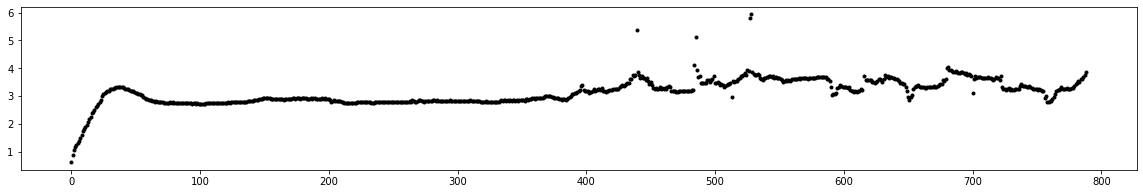

In [126]:
np_detections = np.array([x.to_xyz_wcs()[2] for x in detections])
print(np_detections.size)
plt.plot(range(np_detections.size), np_detections, '.', color='black')

In [127]:
print("to_xyz_ccs: ", detections[0].to_xyz_ccs())
xyz_wcs = np.array(detections[0].to_xyz_wcs())
print("to_xyz_ccs: ", xyz_wcs)

to_xyz_ccs:  [390.5        246.           0.60773585]
to_xyz_ccs:  [0.11406896 0.00941487 0.60773587]


In [128]:
pixel_ccs = [390.5, 246., 0.60796875]
point_wcs = projector.ccs2wcs(pixel_ccs)
print(point_wcs)

[0.11411267518997192, 0.00941847637295723, 0.6079687476158142]


In [129]:
projector.wcs2ccs([0.11411267518997192, 0.00941847637295723, 0.6079687476158142])

array([390.5, 246. ,   0. ])

In [130]:
print("tlwh: ", detections[0].tlwh)
print("to_xyzah_ccs: ",  detections[0].to_xyzah_ccs())
print("to_xyz_ccs: ", detections[0].to_xyz_ccs())
print("to_tlbr_ccs: ", detections[0].to_tlbr_ccs())
print("to_xyzah_wcs: ",detections[0].to_xyzah_wcs())
print("to_xyz_wcs: ", detections[0].to_xyz_wcs())
print("to_xyz_bottom_wcs: ", detections[0].to_xyz_bottom_wcs())

tlwh:  [155.  26. 471. 440.]
to_xyzah_ccs:  [390.5        246.           0.60773585   1.07045455 440.        ]
to_xyz_ccs:  [390.5        246.           0.60773585]
to_tlbr_ccs:  [154  26 625 466]
to_xyzah_wcs:  [1.14068963e-01 9.41486936e-03 6.07735872e-01 1.07045455e+00
 4.40000000e+02]
to_xyz_wcs:  [0.11406896263360977, 0.009414869360625744, 0.6077358722686768]
to_xyz_bottom_wcs:  [1.14068963e-01 3.57998937e-01 6.07735872e-01 1.07045455e+00
 4.40000000e+02]


In [11]:
def crop(img, bboxes):
    cropped_imgs = []
    for bbox in bboxes:
        bbox = [int(round(x)) for x in bbox]
        cropped = img[bbox[1]:bbox[1] + bbox[3], bbox[0]:bbox[0] + bbox[2]]
        cropped_imgs.append(cropped)
    return cropped_imgs

In [46]:

def show_and_calc_similarity(img_name):
    #img_name = "02184.jpg"
    selected = [x for x in dataset if x["img_name"] == img_name][0]
    objs = selected["objects"]
    print("bbox", objs[0]["bbox"])
    print("bbox1", objs[1]["bbox"])
    
    imgs = "/home/eam/MasterThesis/Thesis/deep-sort3d/notebooks/extracted_rs/frames/"
    img = cv2.imread(os.path.join(imgs, img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
    
    obj_1_img = crop(img, [objs[0]["bbox"]])[0]
    obj_2_img = crop(img, [objs[1]["bbox"]])[0]
    plt.subplot(1, 2, 1)
    plt.imshow(obj_1_img)
    plt.subplot(1, 2, 2)
    plt.imshow(obj_2_img)
    plt.show()
    
    obj_1_feature = objs[0]["features"]
    obj_2_feature = objs[1]["features"]
    similarity = 1 - spatial.distance.cosine(obj_1_feature, obj_2_feature)
    print("Similarity: ", similarity)
    

bbox [407, 79, 134, 401]
bbox1 [176, 105, 104, 374]


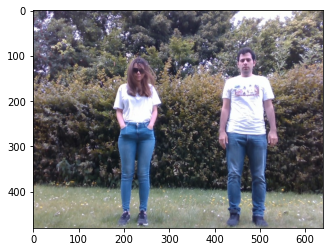

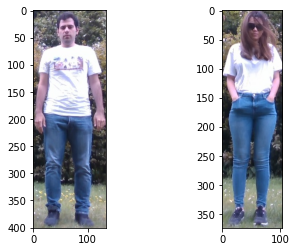

Similarity:  0.8148933948447216


In [47]:
show_and_calc_similarity("02184.jpg")

bbox [248, 105, 107, 356]
bbox1 [138, 101, 123, 373]


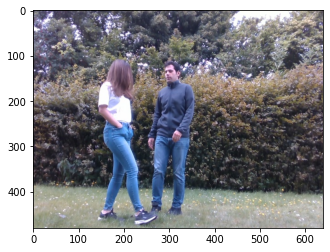

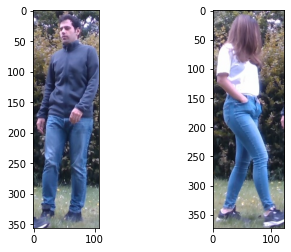

Similarity:  0.7012822875196615


In [48]:
show_and_calc_similarity("03621.jpg")

0.8148933948447216

In [ ]:
img_name = "02184.jpg"